<a href="https://colab.research.google.com/github/adamya-singh/machine-learning-exercises/blob/master/EEG-analysis-Alljoined/Adamya_Singh_AlljoinedChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background

Welcome to the Alljoined Take-Home Challenge! This exercise is designed to allow you to showcase your engineering and problem solving skills. The Challenge consists of different components including:

*   Identifying bugs, and getting the code working. This is designed to test your ability to grapple with real world engineering challenges.
*   Open-ended model improvements. This is designed to to test your ability to find resources to gain context and solve problems, your research intuitions and your ability to scope out priorities.
*   System design questions to understand your ability to develop performant and elegant solutions and evaluate trade-offs.


These tasks were chosen as a setting to see how you think about problems. We purposefully have selected a simple toy problem so the focus is on how you think, and does not require significant machine learning resources. You are welcome to create more cells to help with your work or visualization, or to develop outside of this notebook if it is helpful to you.

Good luck! If you have questions about the framing of the questions, please contact takehome@alljoined.com


### How to Use and Submit this Document

* **Make a copy of this document** and **rename** it **Firstname_Lastname_AlljoinedChallenge**
* Once you’ve completed all tasks, **save and pin your revisions**
* Submit the assignment by responding directly to the email you received (please reply all) with a link to your final document (and any other files you have created for your submission) by November 15, 11:59 PST. Due to the volume of applications, we will not be monitoring the inbox after that time.

After the submission window closes, we will reach out to the top candidates to schedule a final round technical interview, where we will walk through your submission, your thought process, and the details of your proposed solution. While the use of external tools including language models is allowed, please be prepared to explain and justify your solution in the final stage. We value your critical thinking, creativity, and research communication much more than the individual performance of your submission.

# EEG decoding background
At Alljoined, our research centers on neural decoding - the task of uncovering thoughts directly from noninvasive brain scans. Thanks to advances in deep learning, this has now become a feasible research objective, which we push forward through breakthroughs in image, emotion and text decoding.

We collect and work with EEG, and use computational neuroscience and machine learning techniques to decode latent representations from the time series data. The challenge is in ensuring good experiment design, data quality, and modeling techniques to quickly and accurately ingest, process, and map EEG to the best latent representation.

For an overview of EEG, statistical modeling techniques, and representation learning methods, we refer to these articles:
[link1](https://neuraldatascience.io/7-eeg/about_eeg.html),
[link2](https://neuraldatascience.io/7-eeg/erp_group_stats.html),
[link3](https://www.baeldung.com/cs/dl-latent-space)

Here is some of our prior published work:
[MindEye2](https://medarc-ai.github.io/mindeye2/),
[Alljoined 1.6M](https://arxiv.org/abs/2508.18571)

# Project setup

Run the cells below to get started.

In [1]:
# @title Install required packages
!pip install mne openai-clip scikit-learn pandas numpy torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 878.8 kB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368629 sha256=f1473e335fbb5486380cfece24e8af2f4d99c01f50879dde6b33257ecf4a8609
  Stored in directory: /root/.cache/pip/wheels/ab/49/bc/c2342e8e14878210ba4825cf314a53f2570f6fb18b91fce3cf
Successfully built openai-clip


In [2]:
# @title Download data
from pathlib import Path

if not Path("data").exists():
  !gdown 1fL9G8LoiP8_Dhmr-HeVGiD_X7W8tconz&confirm=t
  !unzip -q data.zip -d data

Downloading...
From (original): https://drive.google.com/uc?id=1fL9G8LoiP8_Dhmr-HeVGiD_X7W8tconz
From (redirected): https://drive.google.com/uc?id=1fL9G8LoiP8_Dhmr-HeVGiD_X7W8tconz&confirm=t&uuid=bd53a178-9898-4174-9239-63d8954af855
To: /content/data.zip
100% 1.13G/1.13G [00:03<00:00, 371MB/s]


In [3]:
# @title Import modules and load data

import mne
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import clip
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
DATA_DIR = Path('/content/data/zip/')

raw = mne.io.read_raw_brainvision(DATA_DIR / "data.vhdr", preload=True, verbose=False)
raw.resample(250, verbose=False)  # Downsample to 250 Hz

metadata = pd.read_parquet(DATA_DIR / "metadata.parquet")


In [4]:
annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)

event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

# Align metadata with events (bottom-up alignment)
metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values
print(f"Found {len(events)} stimulus events")

# Create epochs with baseline correction
epochs = mne.Epochs(raw, events, tmin=0.0, tmax=1.0, baseline=(0, 0), preload=True, verbose=False)

Found 20880 stimulus events


# Coding Challenge Part 1: Debug the Signal Processing Pipeline

**Introduction**

Signal processing is fundamental to working with time-series data like EEG. Even small bugs in preprocessing can cascade into major issues downstream, making debugging skills critical. In real-world scenarios, you'll often inherit code that "mostly works" but has subtle issues that degrade performance.

**Context**

We provide helper functions for EEG preprocessing that contain some number of bugs scattered throughout. Some cause crashes, others cause subtle degradation in signal quality that might go unnoticed without careful attention. Some others affect our ability to interpret the data. Your goal is to walk through the process to better understand the data.

**Tasks**

*   Fix all the bugs and explain why each was problematic
*   Add proper documentation to each function
*   Validate output ranges are sensible and add assertions
*   Plot and analyze the data

In [16]:
# Let's first plot the raw EEG

def plot_raw_segment(raw, start=0, duration=1, figsize=(12, 8)):
    sfreq = raw.info['sfreq']
    start_idx = int(start * sfreq)
    end_idx = int((start + duration) * sfreq)

    data, times = raw[:, start_idx:end_idx]
    # Z-score each channel to have similar visual range
    #data = data - np.mean(data, axis=1, keepdims=True)
    #data = data * 1e5
    data = (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)
    spacing = 5

    fig, ax = plt.subplots(figsize=figsize)

    offset = np.arange(len(data)) * spacing

    # Plot each channel
    for i, channel_data in enumerate(data):
        ax.plot(times, channel_data + offset[i], linewidth=0.5,
                label=raw.ch_names[i] if i < 3 else "")

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channels')
    ax.set_title(f'{start}s - {start+duration}s')
    ax.set_yticks(offset)
    ax.set_yticklabels(raw.ch_names)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig, ax

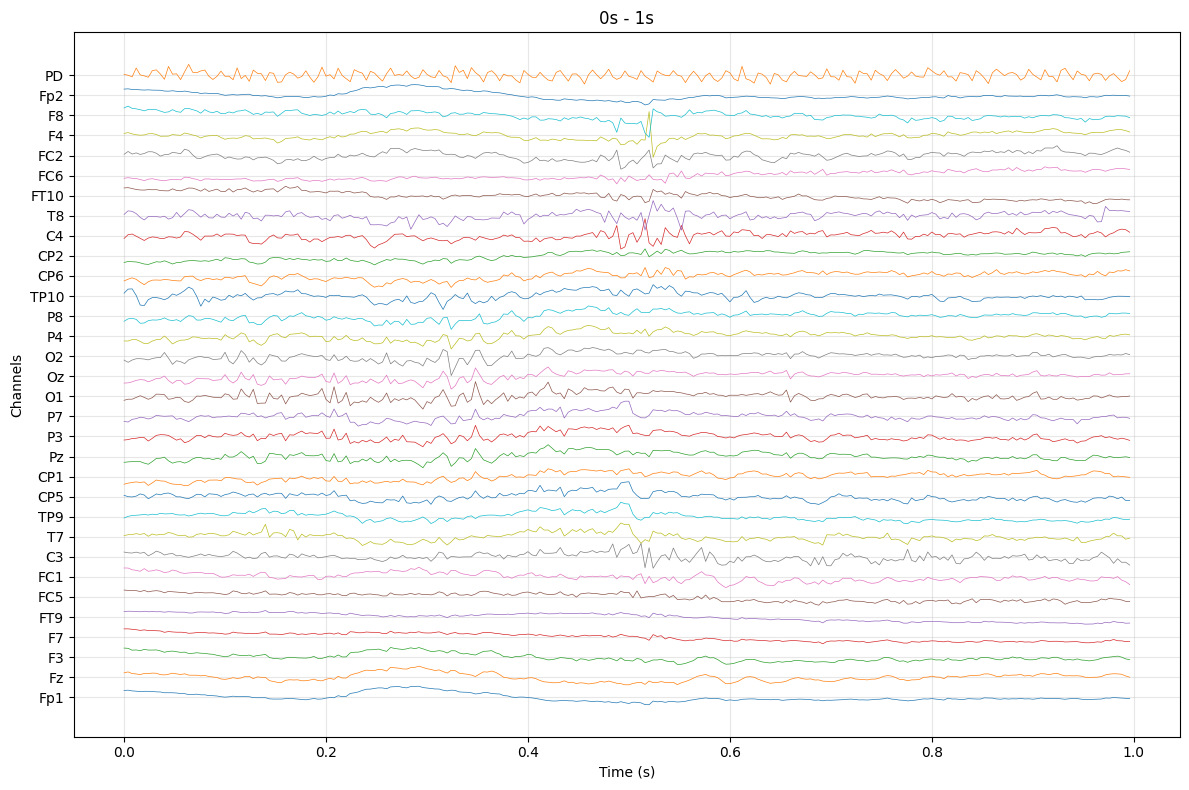

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': '0s - 1s'}, xlabel='Time (s)', ylabel='Channels'>)

In [17]:
# Hint: what should EEG signals look like?
plot_raw_segment(raw, start=0, duration=1)

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


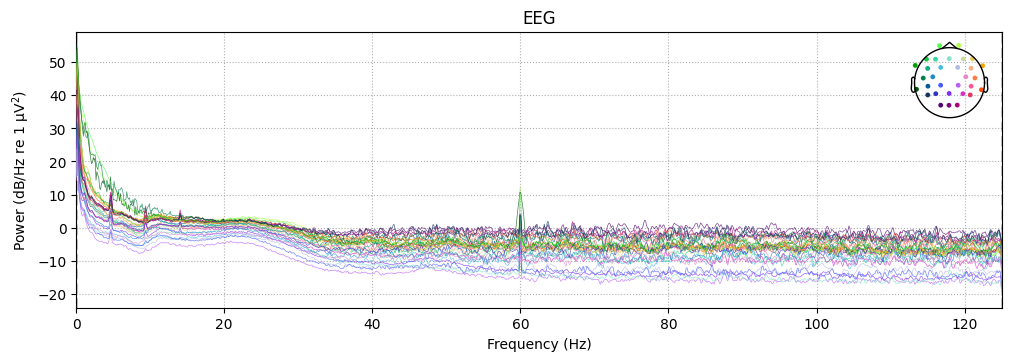

In [ ]:
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)
raw.compute_psd().plot();

Discussion:

1. What can we learn from the time series plot? These are good resources to look at as a starter: [link 1](https://www.learningeeg.com/montages-and-technical-components) [link 2](https://www.learningeeg.com/artifacts). Is there any channel(s) that is not like the others?

2. What can we learn from the PSD? [An example](https://neuroimage.usc.edu/brainstorm/Tutorials/ArtifactsFilter#Interpretation_of_the_PSD)

1. Here is what I observed in the time series plot of the EEG data:
- Between 0.25 and 0.35 seconds, I see a short burst of activity in P8, P4, O2, Oz, O1, P7, P3, Pz, CP1, and CP5 where the spikes are roughly synchronized and larger than usual, it just looks like three bumps.
- Between 0.45 and 0.55 seconds, I see some activity in F8, F4, FC2, FC6, FT10, T8, C4, and also C3, where the spikes are not very synchronized but are much larger.
- The PD channel seems to be oscillating stably up and down without changing its pattern the whole time.

The one channel that is not like the others is the PD channel, which oscillates stably without any change in pattern. This is because in EEG setups, PD is usually a photodiode taped to the screen to monitor screen luminance, which helps synchronize event timing with the exact time the stimulus was presented.

I noticed two short bursts of activity in the plot, the first one was between 0.25 and 0.35 seconds and channels P8 through CP5 seemed to be synchronized and had 3 short spikes. This seems like an actual event related potential rather than noise or an artifact. The second short burst of activity I noticed was between 0.45 and 0.55 seconds, and did not seem to be synchronized. This seemed more like a brief muscle or facial movement.

2. Here is what I observed in the PSD:
- The power readings start high at 0 and come down together and then there is a spike at 5hz from the electrodes at the back of the head. There is another smaller spike half that size at 10hz, and and even smaller spike 1/4 of that size at 15hz. The power readings bunch up around 20 hz and then spread out to cover between -15 and 3 for the rest of the plot, and there is a short spike to 10 at 60hz which looks like minimal power line interference. The front left and back left regions of the brain seem to be reading more power than the other regions.

The peaks I observed at 5hz, 10hz, and 15hz are called harmonics, and they occur in electrodes closer to the back of the head (occipital lobe). The presence of this 5hz peak and the 10/15hz harmonics indicates a periodic visual input, like the flicker of the screen, that is causing this activity.

In [ ]:
# Feel free to make extra code cells for your analysis/experiments.

## Statistical Analysis of ERP Components
Now that you've explored the data structure, implement a statistical analysis to determine whether different image categories elicit distinguishable neural responses in the EEG data.
Your approach should:

Extract meaningful ERP components from the epoched data (consider early visual processing windows)
Implement a systematic comparison between conditions across subjects
Apply appropriate statistical testing to evaluate significance
Visualize the distribution of your results to assess whether you're detecting genuine neural differences or noise

Hint: Consider how you might adapt group-level statistical approaches commonly used in ERP research. For inspiration on statistical methods for ERP analysis, see this reference.

Deliverable:

- Implementation of your statistical analysis
- Visualization and interpretation of results
- Brief explanation of what your p-value distribution tells you about the discriminability of neural responses

# Coding Challenge Part 2: Retrieve semantic content from brain activity

## Overview
This notebook contains a basic EEG processing and retrieval pipeline for the some EEG data where a subject participated in a "rapid serial visual presentation" task, similar to that in [THINGS-EEG2](linkinghub.elsevier.com/retrieve/pii/S1053811922008758). Your task is to improve the retrieval performance by enhancing the design/functionality of the preprocessing and machine learning architecture. All data provided as part of this take-home is fair game so you may use as much or as little as you wish. All code (with the exception of the evaluation cell at the end) is able to be improved in a variety of ways.

## Your Mission
The current pipeline achieves pretty poor performance. Identify and implement improvements to boost decoding accuracy! The included code is meant to be a first pass simple example for a text-based retrieval paradigm, but feel free to use any approach you like.

### Note
Loading the data for this exercise requires at least 15GB of RAM, on the free Google Collab subscription this requires a v5e1-TPU runtime instance.

In [ ]:
annotations = raw.annotations
annotations.description = [desc.replace(' ', '') for desc in annotations.description]
raw.set_annotations(annotations)

event_id = {f'Stimulus/S{i}': i for i in range(1, 23)}
events, _ = mne.events_from_annotations(raw, event_id=event_id, verbose=False)

# Align metadata with events (bottom-up alignment)
metadata_aligned = metadata.iloc[-len(events):].copy().reset_index(drop=True)
events[:, 2] = metadata_aligned['image_index'].values
print(f"Found {len(events)} stimulus events")

# Create epochs
epochs = mne.Epochs(raw, events, tmin=0.0, tmax=1.0, baseline=(0, 0), preload=True, verbose=False)

# Train/test split by blocks
train_mask = metadata_aligned['partition'] == 'stim_train'
test_mask = metadata_aligned['partition'] == 'stim_test'

train_data = epochs[train_mask].get_data()
test_data = epochs[test_mask].get_data()
train_meta = metadata_aligned[train_mask].reset_index(drop=True)
test_meta = metadata_aligned[test_mask].reset_index(drop=True)

Found 20880 stimulus events


In [ ]:
def average_eeg_by_category(eeg_data, metadata):
    """Averages EEG data by category name."""
    grouped_signals = []
    grouped_metadata = []

    for category, group_df in metadata.groupby('category_name'):
        indices = group_df.index.tolist()
        group_signals = eeg_data[indices]
        avg_signal = group_signals.mean(axis=0)

        representative_metadata = group_df.iloc[0].copy()
        representative_metadata["averaged_trial_count"] = len(indices)

        grouped_signals.append(avg_signal)
        grouped_metadata.append(representative_metadata)

    averaged_data = np.stack(grouped_signals)
    averaged_metadata = pd.DataFrame(grouped_metadata).reset_index(drop=True)
    return averaged_data, averaged_metadata

# Average test data by category
test_data, test_meta = average_eeg_by_category(test_data, test_meta)

category_names = test_meta['category_name'].tolist()

# Flatten averaged EEG data
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)

In [ ]:
# This cell may take a few minutes to run if you are not using a GPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

unique_categories = sorted(list(set(train_meta['category_name'].unique()).union(test_meta['category_name'].unique())))

text_tokens = clip.tokenize(unique_categories).to(device)
with torch.no_grad():
    clip_features = clip_model.encode_text(text_tokens)
    clip_features /= clip_features.norm(dim=-1, keepdim=True)

category_to_clip = {cat: clip_features[i].cpu().numpy() for i, cat in enumerate(unique_categories)}

train_targets = np.array([category_to_clip[cat] for cat in train_meta['category_name']])
test_targets = np.array([category_to_clip[cat] for cat in test_meta['category_name']])

print(f"Encoded {len(unique_categories)} categories with CLIP")


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.9MiB/s]


Encoded 1027 categories with CLIP


In [ ]:
# Standardize features
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Train Ridge regression
ridge_model = Ridge().fit(train_data, train_targets)
print(f"Ridge model trained on {train_data.shape[0]} trials")

test_predictions = ridge_model.predict(test_data)

print(f"Predicted embeddings for {len(test_data)} test categories")


Ridge model trained on 16710 trials
Predicted embeddings for 200 test categories


# Evaluation
The following cell is for evaluating your performance, please do not change it. You are welcome to manipulate the input `test_targets` and `test_predictions` variables how you see fit outside this cell.

In [ ]:
# Compute cosine similarities
similarities = cosine_similarity(test_targets, test_predictions)

# Compute top-k accuracies
def compute_topk_accuracy(similarities, k):
    correct = sum(i in np.argsort(similarities[i, :])[-k:] for i in range(len(similarities)))
    return correct / len(similarities)

# Calculate top-k accuracies and chance levels
n_categories = len(category_names)
results = {}
for k in [1, 5, 10]:
    acc = compute_topk_accuracy(similarities, k=k)
    chance = min(k / n_categories, 1.0)
    results[k] = (acc, chance)

# Print results
print("🎯 Retrieval Accuracies:")
for k, (acc, chance) in results.items():
    print(f"   Top-{k}:  {acc:.3f} ({acc:.1%}) | Chance: {chance:.3f} ({chance:.1%})")
print(f"📊 Total test categories: {n_categories}")


🎯 Retrieval Accuracies:
   Top-1:  0.010 (1.0%) | Chance: 0.005 (0.5%)
   Top-5:  0.065 (6.5%) | Chance: 0.025 (2.5%)
   Top-10:  0.105 (10.5%) | Chance: 0.050 (5.0%)
📊 Total test categories: 200


# Software Challenge

**Introduction**

Now you have a sense of the type of analysis we do. It's time to think more about the practical limitation. For this challenge, we would like to get your idea on how to implement the data collection, storage and analysis pipeline in a very flexible, accurate, yet efficient way.

We obviously do not expect you to provide complete implementation in this take-home assignment. Instead, we would like you to focus on high-level designs, but with sufficient details to illustrate how you can solve some of the practical challenges. You are free to use any tools during this challenge, and leverage any existing library/packages. However you are expected to completely undertand the implementation you are proposing, and must be comfortable to defend any details regarding the implementation.

There are three major components in our current data workflow. Read through the following, and choose **ONE** from the three challenges that can best highlight your previous experience.

<a name="challenge1"></a>

---

## Challenge 1: Data Collection

**Context**

On a high level, our data collection pipeline involves presenting visual stimulus to the participants, and record their EEG activity at the same time. For this challenge, we assume that the EEG data are collected with an existing software which is not our main concern. Instead, we focus on implementing a custom piece of python code that can present stimulus with high precision in a flexible way. There are a few practical considerations that may make this problem complicated:

1. Every EEG collection experiment essentially consists of presentation of image or video stimulus in a sequential order that would be pre-determined before the experiment starts. However there are certain visual elements that would not follow a simple sequential order. For example, we might want to display a red dot/cross in the center of the screen that overlay with the stimulus (this helps the participants focus on the current stimulus and are usually called "fixation" in relevant literatures). We may also want to display a screen of text and/or buttons to collect response from participants, which will block later stimulus until a response is received.
1. One of the major stakeholders/user of this codebase would be our computational neuro team, who design the EEG collection experiments. Hence, we would want this codebase to enable anyone with basic python skills to design arbitrary experiments. Specifically, we want to user to be able to easily change the parameters of stimulus content and timing, as well as design new response paradigm. At the same time, we want the codebase to have "battery included", so that common operations like fixation do not need to be re-implemented every time a new experiment is designed. In other words, we want to minimize the amount of code change for potential new experiments.
1. Related to previous point, we want an easy and human-readable way to record all aspects of a particular experimental design, to the extent that given the record, we will be able to reproduce exactly how an experiment was performed.
1. Some of our stimulus are presented as fast as 10Hz (that is 50ms on and 50ms off). Hence, the code should be able to handle stimulus presentation at high temporal precision, and consistently across a long period of time (at least 30 minutes).
1. Some of our experiment involve presenting more than 10K images, which may not fit into the RAM at the same time.
1. We would like to record all aspects of the stimulus presentation as metadata, which include the timestamp of start and end of each stimulus, as well as any other events users might want to record. Innevitably there will be edge cases where the software/hardware crash and fails. In such cases, we would want ganrunteen that the data will not be corrupted, and retain as much information as possible before the crash.

**Problems**

1. Design an implementation of the stimulus presentation codebase. Illustrate your design in whatever way you see fit (diagrams, pseudo code are all good ideas). You do not need to provide any actual code for this sub-problem. However, provide enough details about how your design can address some of the previously mentioned concerns.
1. Pick **ONE** function in your design, and provide an implementation in python. Feel free to call any existing packages/libraries. Also feel free to call any other auxiliary functions in your design that are not actually implemented. You can simply return mock/fake data in those auxiliary functions. Make your submission self-contained and executable (as long as the dependencies are installed). We would recommend picking the one function that best highlight the one of the core ideas in your design that you are most proud of.
1. (Bonus). Once we have presented the stimulus and record both the experiment timing and EEG data, we would need to align the between experimental (stimulus presentation) timing data with the EEG timeseries data. What are some ways you can think of that can align these data with high temporal precision?

<a name="challenge2"></a>

---

## Challenge 2: Data Storage

**Context**

There are many different pieces and modality of data involved in our research. Roughly speaking, they can be classified into raw data (directly collected from experiments), and intermediate/derived data (to support downstream analysis). For this challenge we focus on the storage of raw data, which includes:

1. The collected EEG data and metadata (accompanying hardware information from the EEG collection device).
1. Metadata about a particular collection experiment/session, including the experimental design, the subject and session ID, the time and place (specific data collection station) the session was collected.
1. The stimulus presented during an experiment, and the timestamps of all events that happens during an experiment, including onset and duration of presented stimulus, tiral time, fixation time and any arbitrary user-defined events. (see [Challenge 1](#challenge1) for more context).
1. The participant information (Biographical information and responses to some questionaire) and any experimental notes associated with an experiment/session.

A few concerns that makes this challenge more complicated than it seems:

1. Expect any steps with human in the loop to have error. For example, the stimulus might be named wrong/differently on different machine. The technician might enter the wrong session and/or subject ID during collection. The data files might be named wrong (if there is a standarized filename pattern). The design needs to anticipate as much human error as possible, and either eliminate the possibility of such errors, or be robust enough so the data are still intact and can be easily queried when such error happens.
1. The data are probably generated/used at different locations. For example, when the computational neuro team design the experiments, they will probably do it on their own laptop. When the data collection actually happens, it will happen on dedicated data collection computer. When the data are ready to be used for analysis, we probably want to access them through our centralized analysis HPC. The design need to handle the scattered nature of data.
1. We would like to be able to store and query the data in a very flexible yet efficient way. For example, we need to query not only with simple expressions like "give me data for subject X session Y", but also complicated, trial-by-trial level expressions like "give me all trials with a 'happy' label from participants that are younger than 25". On the other hand, our database can grow large really fast. We routinely run collection sessions with more than 10K trials, and the number of collection sessions will continue to grow as long as we are continuing our research. We do not want the storage and query overhead to grow too much over time.
1. As our research evolves, we would likely incorporate different type and modality of data overtime. For example, we might want to incorporate some eye-tracking data along with EEG data. The proposal needs to be able to incorporate such data in the future without major redesign of the schema.
1. We would like to minimize the data storage footprint as much as possible.
1. We would like some level of version control of the data so they cannot be accidentally overwritern or deleted. Yet we would like to retain the possibility to fix some error in the data when we are absolutely certain.

**Problem**

1. Design the data storage schema and auxiliary codebase. Illustrate your design in whatever way you see fit (diagrams, pseudo code are all good ideas). You do not need to provide any actual code for this sub-problem. However, provide enough details about the storage schema (e.g. what file format and name/path convention should be used? If you want to store some data in a table, what should be the columns? What storage backend should be used?), as well as how your design of the auxiliary codebase can address some of the previously mentioned concerns.
1. Pick **ONE** function/class in your proposed auxiliary codebase, and provide an implementation in python. Feel free to call any existing packages/libraries. Also feel free to call any other functions in your design that are not actually implemented. You can simply return mock/fake data in those functions. Make your submission self-contained and executable (as long as the dependencies are installed). We would recommend picking the one function that best highlight the one of the core ideas in your design that you are most proud of.
1. (Bonus) Do you think it's a good idea to include the storage of stimulus files in such database? Do you think it's a good idea to include intermediate/derived data in such database? If the answer is yes to any, discuss how they should be incorporated into your proposed database design.

<a name="challenge3"></a>

---

## Challenge 3: Preprocessing analysis

**Context**

Once the data are collected and properly stored, we would like a codebase to pre-process all incoming raw data so that they are ready for downstream ML model to digest. Rougly speaking, the preprocessing steps includes signal filtering (high/low/band-pass filtering, drift correction, artifact correction), data epoching (segment continuous EEG timeseries into pieces that align with each trial/stimulus presentation), and potential feature extraction. The specific details of each of these steps is not the main concern of this challenge. You can treat them as elemental functions that returns the correct output given proper input and parameters. Instead, we focus on a framework that orchestrate these different preprocessing steps in a flexible and efficient way. A few concerns make this challenge more complicated than a sequential call of functions:

1. We would like to easily change the parameters of individual steps, as well as how and when to run them. For example, I might want to run a band-pass filter before epoching the data, and then another series of band-pass filter with a range of cutoff frequencies to extract different features from the epoched data. And in such cases we would like to minimize the amount of duplicated code/functions (we do not want a pre-epoch filter function and a post-epoch filter functions if they are 95% the same).
1. We would like the system to be able to cache and re-use intermediate results in an intelligent way. For example, I might want to perform the filtering and epoching, and then extract a power spectrum of each epoch as feature. Later I decided that's a bad idea and I would like to perform ICA on each epoch instead. In such cases, I would not want to run the filtering and epoching again since they did not change.
1. For each pass of pre-processing performed with the corresponding extracted feature, we would like a record of exactly what has been done to the data (including all the functions and parameters), so that given this record and the same set of raw data, we can reproduce exactly the same extracted feature.

**Problems**

1. Design an implementation of the preprocessing framework/codebase. Illustrate your design in whatever way you see fit (diagrams, pseudo code are all good ideas). You do not need to provide any actual code for this sub-problem. However, provide enough details about how your design can address some of the previously mentioned concerns.
1. Pick **ONE** function in your design, and provide an implementation in python. Feel free to call any existing packages/libraries. Also feel free to call any other functions in your design or any elemental preprocessing functions (`bandpass_filter(data, cutoff_freq, ...)`, `epoch_data(data, timestamps, ...)` etc.) that are not actually implemented. You can simply return mock/fake data in those functions. Make your submission self-contained and executable (as long as the dependencies are installed). We would recommend picking the one function that best highlight the one of the core ideas in your design that you are most proud of.
1. (Bonus). Do you think this codebase can handle downstream ML steps as well (i.e. model training, testing, fine-tuning, experimenting on different architectures)? If so, discuss how they can be incorporated into the design.